# Branching ratios

A newly discovered particle was found to be able to decay in two different ways (two different decay channels): $\alpha$ and $\beta$. The probability $f_\alpha$ for decay $\alpha$ to happen is called its _branching ratio_.

## Tasks

Solve the tasks below.
For each task, give reasons for your solution by commenting in the notebook.
In conclusion, summarize your findings and contextualize them. What have you learned? Do the results make sense?

Your results will be examined for plagiarism. Please use your own plot styles, articulate your own thoughts, and present your own experimental approaches.

a) For a fixed number $N$ of observed decays, explain why the number of decays to channel $\alpha$ should follow a binomial distribution.

b) Write down the conditional p.d.f. (aka posterior probability distribution) obtained via Bayes' theorem $P(f_\alpha|\vec{k})$ where $\vec{k}$ are your observations. Explain the parameters and the different terms. What do you want to describe with $P(f_\alpha|\vec{k})$?

c) Assuming a flat prior for the branching ratio $\pi(f_\alpha)=1 \forall f_\alpha\in[0,1]$ calculate and draw the posterior probability distribution for $f_\alpha$ after measuring a single decay, which went to $\alpha$.

d) Using the previous result as a prior, calculate and draw the new posterior after each of the observed additional decays "$\beta$", "$\alpha$", "$\alpha$", "$\beta$"

e) Calculate and draw the posterior after observing 100 decays, with 58 going to $\alpha$.


### Hints

1. It is recommended to not start coding right away.
1. Realize what **one experiment** means in this task and how you then construct your Likelihood.

You can solve this problem by explicitly going through the single steps of the calculations. When representing the distributions with numpy arrays, 'np.sum()' comes in handy in the calculation of the normalization. Alternatively, you can also use the beta pdf which was discussed in the lecture and which is accessible through the scipy.stats package 'from scipy.stats import beta‘.


## Solutions

### Binomial Distribution

a) For a fixed number $N$ of observed decays, explain why the number of decays to channel $\alpha$ should follow a binomial distribution.

Each decay is a Bernoulli trial, because:
1. There are exactly two outcomes: it can *either* go to channel $\alpha$ *or* to channel $\beta$.
2. The probabilities of going to either channel stay fixed.

For one decay:
\begin{gather}
    P(\alpha) = f_\alpha \\
    P(\beta) = 1 - f_\alpha
\end{gather}

When the number of trials $N$ is fixed, a series of *statistically independent* Bernoulli trials is called a Bernoulli process.
A Bernoulli process is described by the binomial distribution,
\begin{gather}
    P(n, k, p) = \binom{n}{k} p^k (1 - p)^{n - k} \\
    P(k, f_\alpha, N) = \binom{N}{k} f_\alpha^k (1-f_\alpha)^{(N-k)}
\end{gather}
where $k$ is the number of "successes", i.e. the number of decays to channel $\alpha$, $N$ is the total number of decays, and $f_\alpha$ is the probability of a decay going to the $\alpha$ channel.

### Bayes' Theorem

b) Write down the conditional p.d.f. (aka posterior probability distribution) obtained via Bayes' theorem $P(f_\alpha|\vec{k})$ where $\vec{k}$ are your observations. Explain the parameters and the different terms. What do you want to describe with $P(f_\alpha|\vec{k})$?

We assume that our observations follow a general model, which depends on a parameter.
Our goal is to estimate that parameter using Bayes' theorem.

In this case the model is a Bernoulli process, described by the binomial distribution.
The binomial distribution is dependent on the probability $p$, which is our parameter.

We start with some notion of what this parameter might be.
This is codified in the prior probability distribution, $\pi(p)$.
In the bayesian sense the function gives the level of confidence (probability) that a certain value for $p$ is correct.

We then make a set of observations, $\vec{x}$.
From this we can calculate the likelihood, $L(\vec{x} | p)$, of these observations given our model,
$$
L(\vec{x} | p) = \prod_{x_i \in \vec{x}} P(x_i, p),
$$
where each $x_i$ is the number of successes in a number of trials $n$.

Finally, we can calculate an estimation of the parameter given our observations.
$$
P(p | \vec{x}) = \frac{L(\vec{x} | p) \, \pi(p)}{\int L(\vec{x} | p) \, \pi(p)\, \mathrm{d} p}.
$$

Substituting the given variables gives us the **Posterior Probability Distribution** for this experiment:
\begin{gather}
    P(f_\alpha|\vec{k}) = \frac{L(\vec{k}|f_\alpha) \, P(f_\alpha)}{\int L(\vec{k}|f_\alpha) \, P(f_\alpha) \, \mathrm{d}f_\alpha}
\end{gather}

As was explained before, this gives us a probability distribution over the possible values of the parameter $f_\alpha$. This lets us estimate what the true value of the original system is.

### First calculation

c) Assuming a flat prior for the branching ratio $\pi(f_\alpha)=1 \forall f_\alpha\in[0,1]$ calculate and draw the posterior probability distribution for $f_\alpha$ after measuring a single decay, which went to $\alpha$.

For a single decay, the previous result can be used directly. We assume a flat prior distribution and only integrate over the interval $f_\alpha \in [0, 1]$.

\begin{gather*}
    P(f_\alpha|\alpha) = \frac{f_\alpha \cdot 1}{\int _0 ^1 f_\alpha \cdot 1 \, \mathrm{d}f_\alpha} \\
    P(f_\alpha|\alpha) = 2 f_\alpha
\end{gather*}

This approach of starting with a prior, making observations, then calculating the posterior to become the next prior is called "updating beliefs".
It is very logical and useful.
However, often the necessary integrals are only numerically integrable, which means lots of time and computing power are needed to find the result.
Here the concept of a "conjugate prior" comes in handy.

The general idea is finding a function specified by some set of "hyperparameters" such that for the given type of experiment the calculated posterior will also be a function of the same form, just with different values for the hyperparameters.

For the Bernoulli process, which is described by a binomial distribution, this conjugate prior is called the beta distribution.
It has the form
$$
\pi(p) = \frac{p^{\alpha - 1} (1 - p)^{\beta - 1}}{\Beta(\alpha, \beta)}, \quad p \in [0,1]
$$
where $\alpha$ and $\beta$ are the hyperparameters and $\Beta$ is the beta function, which serves as a normalizing factor.

The beta distribution function is implemented in the `scipy.stats` package, which we will utilize here.

While the calculation in this question is analytically solvable, the next questions will require the more robust method using conjugate priors. Therefore we will implement it here. The result will also show that this method is equivalent to the analytic function $P(f_\alpha|\alpha) = 2 f_\alpha$.

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

We characterize each prior and posterior distribution by its associated hyperparameters.
We implement this by assigning each distribution a two element array with its parameters.

Given a prior $(\alpha, \beta)$, and an observation $x = (n, k)$, we find the posterior as:
$$
P(p | x) \propto L(x | p) \pi(p)
\propto p^k (1-p)^{n-k} \cdot p^{\alpha-1} (1-p)^{\beta-1}
= p^{\alpha + k - 1} (1-p)^{\beta + n - k - 1}.
$$
The posterior is now specified by the hyperparameters $(\alpha + k, \beta + n - k)$.

In [119]:
def calculate_posterior(prior, n, k):
    posterior = prior + np.array([k, n - k])
    return posterior


A flat prior can be modeled with the hyperparameters $\alpha = \beta = 1$.
We then compute the posterior associated with the observation of one decay going to channel $\alpha$.

In [120]:
prior = np.array([1, 1])

event = (1, 1)

posterior = calculate_posterior(prior, *event)

We display both the prior and posterior in the same plot.
The function `beta.pdf` takes as its first argument the points at which to evaluate, and as its second and third arguments the hyperparameters.

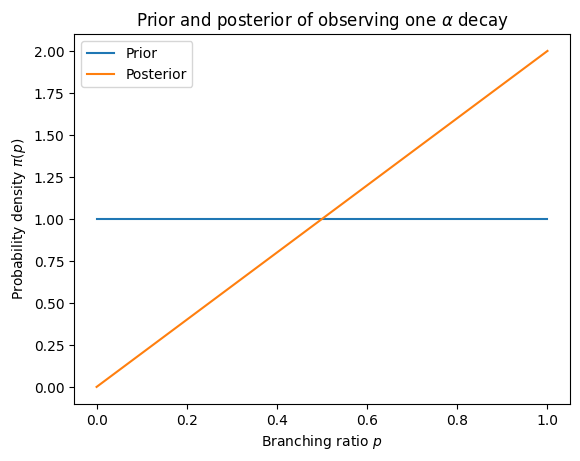

In [102]:
grid = np.linspace(0, 1, 1000)

plt.plot(grid, beta.pdf(grid, *prior), label = "Prior")
plt.plot(grid, beta.pdf(grid, *posterior), label = "Posterior")

plt.title("Prior and posterior of observing one $\\alpha$ decay")
plt.xlabel("Branching ratio $p$")
plt.ylabel("Probability density $\\pi(p)$")

plt.legend()
plt.show()

### d) Multiple observations

We now set the previous result as the new prior and calculate the new posteriors after the events "$\beta$", "$\alpha$", "$\alpha$", "$\beta$". 
We use the function we defined before.

We make use of the fact that calculating the posterior twice, once after event $x_1 = (n_1, k_1)$ and once after event $x_2 = (n_2, k_2)$, gives the same result as calculating the posterior after event $x = x_1 + x_2 = (n_1 + n_2, k_1 + k_2)$.

In [103]:
new_prior = posterior

events = {
    "$\\beta$": (1, 0),
    "$\\beta$, $\\alpha$": (2, 1),
    "$\\beta$, $\\alpha$, $\\alpha$": (3, 2),
    "$\\beta$, $\\alpha$, $\\alpha$, $\\beta$": (4, 2)
}

new_posteriors = [
    calculate_posterior(new_prior, *value) for value in events.values()
]

We can now plot the posteriors for after each event.

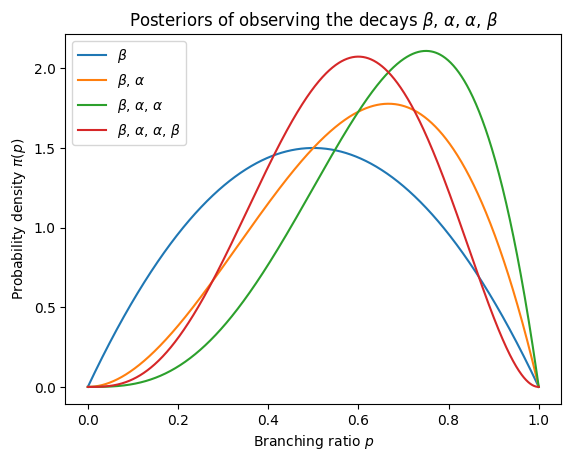

In [104]:
for posterior, label in zip(new_posteriors, events.keys()):
    plt.plot(grid, beta.pdf(grid, *posterior), label = label)

plt.title("Posteriors of observing the decays $\\beta$, $\\alpha$, $\\alpha$, $\\beta$")
plt.xlabel("Branching ratio $p$")
plt.ylabel("Probability density $\\pi(p)$")

plt.legend()
plt.show()

### e) Many observations

Using the same function as before, we can easily calculate the posterior after a large number of decays.
We will again plot the posterior.

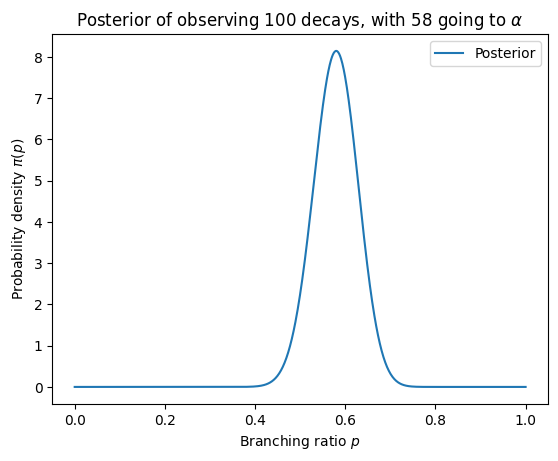

In [122]:
final_event = (100, 58)

final = calculate_posterior(prior, *final_event)

plt.plot(grid, beta.pdf(grid, *final), label = "Posterior")

plt.title("Posterior of observing 100 decays, with 58 going to $\\alpha$")
plt.xlabel("Branching ratio $p$")
plt.ylabel("Probability density $\\pi(p)$")

plt.legend()
plt.show()